In [1]:
import torch
import torch.nn as nn
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os

from torch.utils.data import Dataset, DataLoader
# from torch.utils.data.sampler import Sampler
import torch.optim as optim
import sys
sys.path.append('../')

from dataset import LbpDataset, train_transforms, val_transforms, test_transforms, collate_fn, get_data
from visualize import visualize
# from rcnn_model import fasterrcnn_resnet201_fpn, FastRCNNPredictor
from engine import evaluate
import utils
from train_lbp import get_train_test_list

In [2]:
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone, _validate_trainable_layers
from torchvision.ops.feature_pyramid_network import LastLevelP6P7
from torchvision.models.detection.retinanet import RetinaNet
from torch.hub import load_state_dict_from_url
from torchvision.models.detection.backbone_utils import mobilenet_backbone

In [3]:
from torchvision.models.detection.retinanet import retinanet_resnet50_fpn
from torchvision.models.detection.faster_rcnn import fasterrcnn_mobilenet_v3_large_fpn
# model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
# model = retinanet_resnet50_fpn(pretrained=True)

In [4]:
def retinanet_resnet18_fpn(pretrained=False, progress=True,
                           num_classes=91, pretrained_backbone=True, trainable_backbone_layers=None, **kwargs):
    trainable_backbone_layers = _validate_trainable_layers(
        pretrained or pretrained_backbone, trainable_backbone_layers, 5, 3)

    if pretrained:
        # no need to download the backbone if pretrained is set
        pretrained_backbone = False
    # skip P2 because it generates too many anchors (according to their paper)
    backbone = resnet_fpn_backbone('resnet18', pretrained_backbone, returned_layers=[2, 3, 4],
                                   extra_blocks=LastLevelP6P7(256, 256), trainable_layers=trainable_backbone_layers)
    model = RetinaNet(backbone, num_classes, **kwargs)
#     if pretrained:
#         state_dict = load_state_dict_from_url(model_urls['retinanet_resnet50_fpn_coco'],
#                                               progress=progress)
#         model.load_state_dict(state_dict)
#         overwrite_eps(model, 0.0)
    return model

In [5]:
from torchvision.models.detection.anchor_utils import AnchorGenerator


In [6]:
# anchor_sizes = ((32, 64, 128, 256, 512, ), ) * 5
# print(anchor_sizes)
# aspect_ratios = ((0.5, 0.75, 1.0, 1.5, 2.0),) * len(anchor_sizes)
# aspect_ratios

In [7]:
def retinanet_mobilenet_fpn(pretrained=False, progress=True,
                           num_classes=91, pretrained_backbone=True, trainable_backbone_layers=None, **kwargs):
    trainable_backbone_layers = _validate_trainable_layers(
        pretrained or pretrained_backbone, trainable_backbone_layers, 5, 3)

    if pretrained:
        # no need to download the backbone if pretrained is set
        pretrained_backbone = False
    # skip P2 because it generates too many anchors (according to their paper)
#     backbone = resnet_fpn_backbone('resnet50', pretrained_backbone, returned_layers=[2, 3, 4],
#                                    extra_blocks=LastLevelP6P7(256, 256), trainable_layers=trainable_backbone_layers)
    anchor_sizes = ((32, 64, 128, 256, 512), ) * 3
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
    rpn_anchor_generator=AnchorGenerator(anchor_sizes, aspect_ratios)
    
#     backbone = mobilenet_backbone("mobilenet_v3_small", pretrained_backbone, True,
#                                   trainable_layers=trainable_backbone_layers)
    
    backbone = mobilenet_backbone("mobilenet_v3_large", pretrained_backbone, True,
                                  trainable_layers=trainable_backbone_layers)    
    model = RetinaNet(backbone, num_classes, anchor_generator=rpn_anchor_generator, **kwargs)
#     if pretrained:
#         state_dict = load_state_dict_from_url(model_urls['retinanet_resnet50_fpn_coco'],
#                                               progress=progress)
#         model.load_state_dict(state_dict)
#         overwrite_eps(model, 0.0)
    return model

In [8]:
import easydict 
args = easydict.EasyDict({ "batch_size": 4, 
                          "epochs": 90, 
                          "data": 0, 
                          'lr':0.002,
                         'momentum':0.9,
                         'weight_decay':1e-4,
                         'start_epoch':0,
                         'gpu':0,
                          'workers':12,
                         'print_freq':1000,
                         'output_dir':'../trained_model/retinanet_resnet50_fpn/'})

In [9]:
from pathlib import Path
path = Path(args.output_dir.split('checkpoint')[0])
path.mkdir(parents=True, exist_ok=True)  

In [10]:
ngpus_per_node = torch.cuda.device_count()
print(ngpus_per_node)
GPU_NUM = args.gpu # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
print(device)

1
cuda:0


In [65]:
from dataset_util import CLASS_MAPPER
from sklearn.model_selection import train_test_split
df = pd.read_csv('../../data/df.csv')
df.label = df.label.apply(lambda x : CLASS_MAPPER[str(x)])
df['label_id'] = df.label.apply(lambda x : 0. if 'Benign' in x or 'Negative' in x else 1.)
df = df[df['label_id'] == 1] 
df['xmax'] = df.apply(lambda x : x['xmin'] + x['w'], axis=1)
df['ymax'] = df.apply(lambda x : x['ymin'] + x['h'], axis=1)
df['area'] = df.apply(lambda x : x['w'] * x['h'], axis=1)
df = df[['ID', 'file_name', 'task', 'bbox', 'xmin', 'ymin', 'xmax', 'ymax', 'w', 'h', 'label',
       'occluded','area', 'des', 'cell_type', 'label_id']] 

df_group = df.groupby('file_name')
df_list = df.file_name.unique()
len(df_list)
train_list, test_list = train_test_split(df_list, test_size=0.25, random_state=42)
print('total {} train {} test {}'.format(len(df_list), len(train_list), len(test_list)))

train_list = [get_data(img_id, df_group) for img_id in train_list]
test_list = [get_data(img_id, df_group) for img_id in test_list]
print(len(train_list))
print(len(test_list))


total 7176 train 5382 test 1794
5382
1794


In [14]:
test_list[0]

{'image_id': 'patch_images/2021.01.11/LBC198-20210106(1)/LBC198-20210106(1)_737.png',
 'boxes': array([[ 305, 1280,  445, 1448],
        [1397, 1444, 1501, 1552]]),
 'labels': array([1., 1.]),
 'size': array([[140, 168],
        [104, 108]]),
 'area': array([[23520],
        [11232]]),
 'ID': array([[4127],
        [4127]])}

In [ ]:
def get_train_test_list(df_dir) :
    df = pd.read_csv(df_dir)
    df['label_id'] = df.label.apply(lambda x : 0. if 'Benign' in x or 'Negative' in x else 1.)

#     df['label_id'] = df.label.apply(lambda x : 1 if 'ASC-US' in x or 'ASC-US with HPV infection' in x 
#                                     or 'AS' in x else 0.)
    df = df[df['label_id'] == 1]    
    
    df['xmax'] = df.apply(lambda x : x['xmin'] + x['w'], axis=1)
    df['ymax'] = df.apply(lambda x : x['ymin'] + x['h'], axis=1)
    df['area'] = df.apply(lambda x : x['w'] * x['h'], axis=1)
    df = df[['ID', 'file_name', 'task', 'bbox', 'xmin', 'ymin', 'xmax', 'ymax', 'w', 'h', 'label',
           'occluded','area', 'des', 'cell_type', 'label_id']] 
    
    df_group = df.groupby('file_name')
    df_list = df.file_name.unique()
    train_list, test_list = train_test_split(df_list, test_size=0.25, random_state=42)
    print('total {} train {} test {}'.format(len(df_list), len(train_list), len(test_list)))

    train_list = [get_data(img_id, df_group) for img_id in train_list]
    test_list = [get_data(img_id, df_group) for img_id in test_list]

    print(len(train_list))
    print(len(test_list))   
    
    return train_list, test_list

In [12]:
from dataset_util import CLASS_MAPPER
df = pd.read_csv('../../data/df.csv')
df.label = df.label.apply(lambda x : CLASS_MAPPER[str(x)])
print(df.shape)
# Data loading code#
train_list, test_list = get_train_test_list(df)
train_dataset = LbpDataset(train_list, default_path='/home/Dataset/scl/', transform=train_transforms)
test_dataset = LbpDataset(test_list, default_path='/home/Dataset/scl/', transform=val_transforms)  

(9735, 12)
total 7176 train 5382 test 1794
5382
1794


In [12]:
image, target = next(iter(train_dataset))
target

{'boxes': tensor([[ 675.2947,  949.6309,  734.8608, 1010.5645],
         [ 620.0273,  611.5096,  686.3483,  680.8066],
         [ 737.9312,  933.5015,  787.6719, 1008.7723],
         [ 566.6021,  679.6118,  676.5229,  762.6487]]),
 'labels': tensor([1, 1, 1, 1]),
 'image_id': tensor([6846]),
 'area': tensor([ 9894., 12528., 10206., 24881.]),
 'iscrowd': tensor([0, 0, 0, 0])}

In [13]:
train_sampler = torch.utils.data.RandomSampler(train_dataset)
test_sampler = torch.utils.data.SequentialSampler(test_dataset)

train_loader = DataLoader(
    train_dataset, batch_size=args.batch_size,
    sampler=train_sampler, num_workers=args.workers,
    collate_fn=utils.collate_fn)

test_loader = DataLoader(
    test_dataset, batch_size=args.batch_size,
    sampler=test_sampler, num_workers=args.workers,
    collate_fn=utils.collate_fn)

In [15]:
num_classes = 2
img_size=1200
# model = retinanet_mobilenet_fpn(pretrained=False, min_size=img_size, max_size=img_size, num_classes=2)
backbone_model = retinanet_resnet50_fpn(pretrained=True, min_size=img_size, max_size=img_size)
model = retinanet_resnet50_fpn(pretrained=False, min_size=img_size, max_size=img_size, num_classes=2)
# model = retinanet_resnet18_fpn(pretrained=False, min_size=img_size, max_size=img_size, num_classes=2)

model.backbone.load_state_dict(backbone_model.backbone.state_dict())
model.head.regression_head.load_state_dict(backbone_model.head.regression_head.state_dict())
model.head.classification_head.conv.load_state_dict(backbone_model.head.classification_head.conv.state_dict())
torch.nn.init.normal_(model.head.classification_head.cls_logits.weight, std=0.01)
print('backup and init')

# model = torch.nn.DataParallel(model, device_ids=[0, 1, 2])

device = torch.device('cuda')
model.to(device)
print('model is loaded to gpu')

backup and init
model is loaded to gpu


In [15]:
# model = retinanet_mobilenet_fpn(pretrained=False, min_size=1024, max_size=1024, num_classes=2)
# torch.save(model.state_dict(), 'ret1.pt')

# model = retinanet_resnet18_fpn(pretrained=False, min_size=1024, max_size=1024, num_classes=2)
# torch.save(model.state_dict(), 'ret2.pt')

# model = retinanet_resnet50_fpn(pretrained=False, min_size=1024, max_size=1024, num_classes=2)
# torch.save(model.state_dict(), 'ret3.pt')


In [16]:
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.Adam(params, lr=args.lr, weight_decay=args.weight_decay)
optimizer = torch.optim.SGD(
       params, lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 30, 45, 60, 75], 
                                                    gamma=0.5)

In [17]:
# evaluate(model, test_loader, device=device)    

In [18]:
from train_lbp import train_one_epoch

start_time = time.time()
for epoch in range(args.epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, args.print_freq)
    lr_scheduler.step()
    
    if epoch > 60 and epoch % 5 == 0 :
        if args.output_dir:
            checkpoint = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'args': args,
                'epoch': epoch
            }
            utils.save_on_master(
                checkpoint,
                os.path.join(args.output_dir, 'model_{}.pth'.format(epoch)))
            utils.save_on_master(
                checkpoint,
                os.path.join(args.output_dir, 'checkpoint.pth'))

    if epoch > 40 and epoch % 5 == 0 :
        # evaluate after every epoch
        evaluate(model, test_loader, device=device)    
print('total time is {}'.format(time.time() - start_time))    

Epoch: [0]  [   0/1411]  eta: 0:54:33  lr: 0.002000  loss: 1.5881 (1.5881)  classification: 1.1343 (1.1343)  bbox_regression: 0.4538 (0.4538)  time: 2.3202  data: 1.6928  max mem: 5284
Epoch: [0]  [1000/1411]  eta: 0:04:16  lr: 0.002000  loss: 0.7304 (1.0674)  classification: 0.4175 (0.4921)  bbox_regression: 0.3153 (0.5753)  time: 0.6279  data: 0.0103  max mem: 5557
Epoch: [0]  [1410/1411]  eta: 0:00:00  lr: 0.002000  loss: 0.6938 (0.9641)  classification: 0.3379 (0.4544)  bbox_regression: 0.3129 (0.5097)  time: 0.6197  data: 0.0104  max mem: 5557
Epoch: [0] Total time: 0:14:43 (0.6258 s / it)
Epoch: [1]  [   0/1411]  eta: 0:51:32  lr: 0.002000  loss: 0.8297 (0.8297)  classification: 0.4019 (0.4019)  bbox_regression: 0.4278 (0.4278)  time: 2.1914  data: 1.5778  max mem: 5557
Epoch: [1]  [1000/1411]  eta: 0:04:18  lr: 0.002000  loss: 0.5158 (0.6751)  classification: 0.2637 (0.3322)  bbox_regression: 0.2537 (0.3429)  time: 0.6274  data: 0.0102  max mem: 5579
Epoch: [1]  [1410/1411]  eta

In [66]:
model = retinanet_resnet50_fpn(pretrained=False, min_size=img_size, max_size=img_size, num_classes=2)
pretrained = torch.load(args.output_dir + 'model_65.pth')
pretrained['model']
model.load_state_dict(pretrained['model'])
model.to(device)
print('gpu loading')

gpu loading


In [88]:
test_loader = DataLoader(
    test_dataset, batch_size=4,
    num_workers=args.workers, shuffle=True,
    collate_fn=utils.collate_fn)

In [89]:
import time

model.eval()
images, targets = next(iter(test_loader))
print(len(images))
images = list(img.to(device) for img in images)
with torch.no_grad():
    start_time = time.time()
    outputs = model(images)
    print('time is ', time.time() - start_time)
    
images = [image.to('cpu') for image in images]
outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]    


4
time is  0.29590511322021484


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


patch_images/2021.01.12/LBC233-20210107(1)/LBC233-20210107(1)_1196.png
tensor([0.9133, 0.2143, 0.2081, 0.1986, 0.1970, 0.1918, 0.1853, 0.1809, 0.1788,
        0.1783, 0.1771, 0.1694, 0.1622, 0.0749, 0.0560, 0.0516])
(1200, 1200, 3)


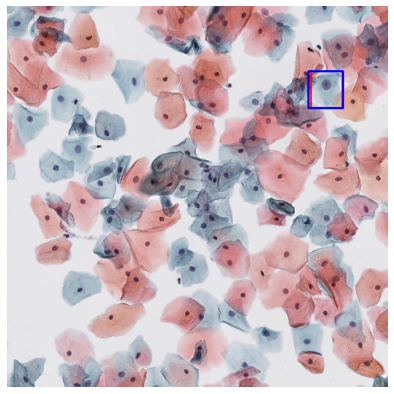

In [93]:
from visualize import visualize
IMAGE_NUM = 3
image = images[IMAGE_NUM].numpy()
image = np.transpose(image, (1, 2, 0))
img_id = targets[IMAGE_NUM]['image_id'].item()
img_path = df[df['ID']==img_id].file_name.values[0]
print(img_path)
ground_boxes = targets[IMAGE_NUM]['boxes']
out_boxes = outputs[IMAGE_NUM]['boxes']
out_scores = outputs[IMAGE_NUM]['scores']
print(out_scores)

pred_boxes = []
for b, s in zip(out_boxes, out_scores) :
    if s > 0.5 :
        pred_boxes.append(b.numpy())

visualize(image, ground_boxes, pred_boxes)        

In [55]:
df[df['file_name'] == 'patch_images/2021.01.12/LBC308-20210108(1)/LBC308-20210108(1)_1445.png']

,ID,file_name,task,bbox,xmin,ymin,w,h,label,occluded,des,cell_type,label_id
1838,1412,patch_images/2021.01.12/LBC308-20210108(1)/LBC...,[ASCUS] LBC308,"[810, 1133, 115, 320]",810,1133,115,320,Carcinoma,0,NaN,Candida albicans,1.0


In [46]:
targets

({'boxes': tensor([[196.2891, 295.3125, 293.5547, 361.5234],
          [806.8359, 211.5234, 883.5938, 279.4922]]),
  'labels': tensor([1, 1]),
  'image_id': tensor([5918]),
  'area': tensor([18758., 15196.]),
  'iscrowd': tensor([0, 0])},
 {'boxes': tensor([[474.6094, 663.8672, 541.9922, 851.3672]]),
  'labels': tensor([1]),
  'image_id': tensor([1412]),
  'area': tensor([36800.]),
  'iscrowd': tensor([0])},
 {'boxes': tensor([[  7.6172, 253.1250, 127.1484, 337.5000],
          [642.7734, 403.1250, 718.9453, 478.1250]]),
  'labels': tensor([1, 1]),
  'image_id': tensor([2687]),
  'area': tensor([29376., 16640.]),
  'iscrowd': tensor([0, 0])},
 {'boxes': tensor([[1027.1484,  526.1719, 1108.5938,  622.2656]]),
  'labels': tensor([1]),
  'image_id': tensor([6415]),
  'area': tensor([22796.]),
  'iscrowd': tensor([0])})